In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

In [ ]:
#===========================================================
# File Name : B_DA_RETL_CHURN MODEL                           
# Description :                                             
# Date : 2020-11-12                                         
# Writer : Yoon Jun Beom
# Packages :                                                
# Note :                           
#===========================================================

# Data Preprocessing

In [ ]:
# library import 
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [4]:
# 가맹점 별 운영정보 데이터
base = pd.read_csv(r".\b_da_retl_churn_anl_md_tmp_table.csv")
base.drop("레코드 수", axis= 1, inplace = True)

base = base[['reg_no','amt_day_cnt', 'avg_amt', 'avg_cnt', 'avg_mm_amt', 'avg_mm_cnt',
       'bf_month_diff_amt', 'bf_month_diff_cnt', 'churn_yn', 'high_lw_term',
       'join_term', 'last_xmit_date', 'm3_sd_amt', 'm3_sd_cnt', 'm_00_app_amt',
       'm_00_app_cnt', 'm_01_app_amt', 'm_01_app_cnt', 'm_02_app_amt',
       'm_02_app_cnt', 'm_03_app_amt', 'm_03_app_cnt', 'm_04_app_amt',
       'm_04_app_cnt', 'm_05_app_amt', 'm_05_app_cnt', 'max_amt_month',
       'min_amt_month', 'min_mm_amt', 'min_mm_cnt', 'min_xmit_date',
       'month_cnt', 'mx_mm_amt', 'mx_mm_cnt', 'mx_xmit_date', 
       'sd_amt', 'sd_mm_amt', 'sd_mm_cnt', 'sum_amt', 'sum_cnt',
       'wk2_amt_diff', 'wk2_cnt_diff']]

In [6]:
# 가맹점코드 매핑, 분류 조정
map_code_info = pd.read_csv(r".\b_svr_map_code_info.csv")
map_code_info.drop(['레코드 수', 'load_dtm'], axis = 1, inplace = True)

li = [ 
["부페", "중식", "퓨전/기타음식점", "한식-일반음식점", "양식", "일식/수산물", "분식/휴게음식점", "패스트푸드/제과점"]	, "음식점" ,
["실내스포츠시설운영업", "실외스포츠시설운영업", "스포츠시설운영업"]	, "스포츠시설운영업",
["예체능계학원", "외국어학원", "일반교과학원", "기타학원", "학습지/코칭교육"]	, "학원",
["자동차및부품판매점", "자동차정비/세차/주차장"]	, "자동차관련판매점",
["유흥주점-무도/가무", "일반유흥주점"]	, "주점",
["독서실/도서관"]	, "기타시설운영업",
["세탁/가사/전문서비스", "주택수리서비스", "용품수리서비스"]	, "대행/용역/인력알선",
["약국/한약방", "유사의료업", "의료관련서비스업"]	, "병원",
["예식/의례/관혼상제"]	, "수의업"
]    
a = []  
b = []

for i in li:
    if type(i) == list :
        a.append(i)
    else :
        b.append(i)
        
for i, j in zip(a, b):
    map_code_info['cd_lv2_nm'].replace(i, j, inplace= True)        

In [7]:
# 가맹점 정보 매핑
real_data = pd.read_csv(r".\L1_10_01_이탈가맹점 매출현황_v2.csv", dtype={'reg_no': 'str'})

In [8]:
real_data.columns

Index(['C_전월_M', 'MM_FLAG', 'total_yearmonth', '계산1', 'C_이탈구간_위험여부',
       'MM_FLAG(복사본)', '레코드 수', 'agency_code', 'sum_amt', '매출건수', 'churn_prob',
       '이탈등급', 'coord_x', 'coord_y', '주소', '사업자명', 'gungu_cd', 'gungu_nm',
       'join_term', '전화번호', '사업자번호', 'rtl_agency_name', 'sido_nm(복사본)',
       'sido_nm', 'svr_code', 'svr_service_name(복사본)', 'svr_service_name',
       'xmit_month'],
      dtype='object')

In [9]:
real_data.groupby('xmit_month')['사업자번호'].nunique()

xmit_month
202010    78984
202011    78984
202012    78992
Name: 사업자번호, dtype: int64

In [13]:
# 가맹점 정보 매핑
debit_retl = pd.read_csv(r".\debit_retl.csv", dtype='str')

In [14]:
debit_retl = debit_retl[['reg_no','h_code','dbr_new_svr_code']]
map_code_info = map_code_info[['map_cd','map_gubun','cd_lv2_nm']]
debit_retl = debit_retl.merge(map_code_info.query("map_gubun == 'V'"), 'left', left_on= 'dbr_new_svr_code', right_on = 'map_cd')

In [15]:
month_tot = base.copy()

In [16]:
month_tot['reg_no'] = month_tot.reg_no.astype("str")

In [17]:
# Feature engineering (비중)
for i in range(6):
    month_tot[f'm{str(i+1)}_cnt_rto'] = month_tot[f'm_{str(i).zfill(2)}_app_cnt'] / month_tot['sum_cnt'] 
    month_tot[f'm{str(i+1)}_amt_rto'] = month_tot[f'm_{str(i).zfill(2)}_app_amt'] / month_tot['sum_amt'] 

# MoM (전월 대비 증감율)
for i in range(5):        
    month_tot[f'm{str(i).zfill(2)}_cnt_updn_rto'] = (month_tot[f'm_{str(i).zfill(2)}_app_cnt'] / month_tot[f'm_{str(i+1).zfill(2)}_app_cnt']) -1 
    month_tot[f'm{str(i).zfill(2)}_amt_updn_rto'] = (month_tot[f'm_{str(i).zfill(2)}_app_amt'] / month_tot[f'm_{str(i+1).zfill(2)}_app_amt']) -1 

In [18]:
month_tot.replace([np.inf, -np.inf], np.nan, inplace = True)

In [19]:
for col in month_tot.columns : # [month_tot.columns.str.contains(r"(_rto)")]
    if month_tot[col].dtype == 'object': 
        pass 
    month_tot.fillna({col:0}, inplace = True)

month_tot['avg_cnt_updn_rto'] = month_tot[month_tot.columns[month_tot.columns.str.contains(r"(_cnt_updn_rto)")]].mean(1)
month_tot['avg_amt_updn_rto'] = month_tot[month_tot.columns[month_tot.columns.str.contains(r"(_amt_updn_rto)")]].mean(1)

base_tot = month_tot.merge(debit_retl[['reg_no','cd_lv2_nm']], 'inner', on = 'reg_no')

base_tot = base_tot[base_tot.cd_lv2_nm.notna()]

In [20]:
# 운영했던 일자 수
base_tot['norm_wrk_day'] = \
pd.to_datetime(base_tot.mx_xmit_date, format = "%Y%m%d") - pd.to_datetime(base_tot.min_xmit_date, format = "%Y%m%d") + np.timedelta64(1, 'D')
base_tot['norm_wrk_day'] = base_tot.norm_wrk_day / np.timedelta64(1, 'D')

In [21]:
# 매출일 수 / 운영일 수
base_tot['amt_day_rto'] = base_tot.amt_day_cnt / base_tot.norm_wrk_day

In [22]:
reg_churn_model = base_tot.drop(["mx_xmit_date", "last_xmit_date","min_xmit_date", "norm_wrk_day", "amt_day_cnt",
                      "min_mm_amt", "mx_mm_amt", "max_amt_month", "min_amt_month", "mx_mm_cnt", "min_mm_cnt"], axis = 1)

# Build Model

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

In [24]:
reg_churn_model['churn_yn'] = reg_churn_model.churn_yn.factorize()[0]
reg_churn_model['cd_lv2_nm'] = reg_churn_model.cd_lv2_nm.factorize()[0]

y = reg_churn_model['churn_yn'].values
X = reg_churn_model.drop(['reg_no','churn_yn'], axis = 1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [30]:
m = round(np.sqrt(len(reg_churn_model.drop(['reg_no','churn_yn'], axis = 1).columns)),0)

In [32]:
rf = RandomForestClassifier(n_estimators=100, max_depth= int(m), random_state=1)

In [33]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [34]:
print('Model accuracy score with 10 decision-trees : {0:0.4f}'.format(accuracy_score(y_test, y_pred.round())))

Model accuracy score with 10 decision-trees : 0.9453


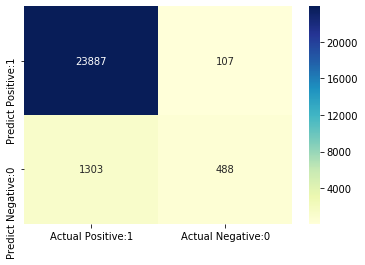

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred.round())
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# Select Cutoff (0.35)

In [36]:
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score

In [37]:
# 이탈 가맹점: 약 6.7%
print(reg_churn_model.churn_yn.value_counts())
print(reg_churn_model.churn_yn.value_counts() / reg_churn_model.churn_yn.value_counts().sum())

0    80149
1     5798
Name: churn_yn, dtype: int64
0    0.93254
1    0.06746
Name: churn_yn, dtype: float64


In [38]:
# find cut off
y_prob = rf.predict_proba(X_test)
i = 0.3
data = []
while True : 
    if i > 0.9 :
        break
    y_pred = (y_prob[:,1] >= i).astype("int")
    data.append([i,accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred),f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)])
    i = i + 0.05

In [39]:
result = pd.DataFrame(data)
result.columns = ['cutoff','accuracy', 'precision','recall', 'f1_score', 'roc_auc_score']
result # 0.35 

,cutoff,accuracy,precision,recall,f1_score,roc_auc_score
0,0.30,0.945472,0.591449,0.695142,0.639117,0.829650
1,0.35,0.947295,0.621076,0.618649,0.619860,0.795238
2,0.40,0.947683,0.655853,0.519263,0.579620,0.749462
3,0.45,0.948420,0.735926,0.401452,0.519509,0.695350
4,0.50,0.945317,0.820168,0.272473,0.409053,0.634007
5,0.55,0.940624,0.992424,0.146287,0.254988,0.573102
6,0.60,0.936358,1.000000,0.083752,0.154560,0.541876
7,0.65,0.931588,1.000000,0.015075,0.029703,0.507538
8,0.70,0.930541,0.000000,0.000000,0.000000,0.500000
9,0.75,0.930541,0.000000,0.000000,0.000000,0.500000


# K-fold test (k = 3)
##### stratified k-fold cross-validation (shuffle)

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit

In [41]:
skf = StratifiedShuffleSplit(n_splits=3)

In [42]:
rf = RandomForestClassifier(n_estimators=50, random_state=1)

In [43]:
for idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_test)
    y_pred = (y_prob[:,1] >= 0.35).astype("int")
    print(f"______________{idx}______________") 
    print(f"accuracy_score : {accuracy_score(y_test, y_pred):0.4f}")
    print(f"f1_score : {f1_score(y_test, y_pred):0.4f}")
    print(f"precision_score : {precision_score(y_test, y_pred):0.4f}")
    print(f"recall_score : {recall_score(y_test, y_pred):0.4f}")
    print(f"_______________________________") 

______________0______________
accuracy_score : 0.9558
f1_score : 0.6812
precision_score : 0.6634
recall_score : 0.7000
_______________________________
______________1______________
accuracy_score : 0.9510
f1_score : 0.6489
precision_score : 0.6284
recall_score : 0.6707
_______________________________
______________2______________
accuracy_score : 0.9560
f1_score : 0.6813
precision_score : 0.6667
recall_score : 0.6966
_______________________________


# Parameter Select 
#### GridSearch

In [44]:
from sklearn.model_selection import GridSearchCV

In [50]:
param_grid = {
    'max_depth': [5,6,7,8,9,10,14,16,18], # sqrt(d), log2(d)
    'n_estimators': [10, 50, 100],
}

In [51]:
estimator = RandomForestClassifier()

In [52]:
skf = StratifiedShuffleSplit(n_splits=3)

In [53]:
grid_search = GridSearchCV(estimator = estimator, 
                           param_grid = param_grid, 
                           cv = skf,
                           n_jobs = -1)

# fit with (x_train, y_train)
grid_search.fit(X, y)
print(f"best_parameter : {grid_search.best_params_}")

best_parameter : {'max_depth': 16, 'n_estimators': 100}


# Feature importance

In [54]:
best_model = grid_search.best_estimator_

In [57]:
best_model.feature_importances_

array([0.01247622, 0.00930181, 0.01114551, 0.01206134, 0.07034498,
       0.07998167, 0.01142179, 0.02692958, 0.01299106, 0.01117954,
       0.01566059, 0.0101672 , 0.01102466, 0.00983729, 0.00812659,
       0.00800329, 0.00675054, 0.00644339, 0.00801827, 0.00634291,
       0.00796391, 0.00947352, 0.00640098, 0.01370988, 0.01151572,
       0.01322793, 0.01110888, 0.01203984, 0.12247477, 0.09109185,
       0.04105571, 0.02955873, 0.01368709, 0.01329073, 0.00952371,
       0.00885521, 0.00910248, 0.00740178, 0.00986239, 0.00824688,
       0.01329592, 0.01389469, 0.03627301, 0.02566299, 0.00903059,
       0.00956022, 0.00711473, 0.0071978 , 0.00584035, 0.00582834,
       0.00513814, 0.00517842, 0.01769046, 0.01382717, 0.00987616,
       0.01679076])

In [ ]:
feature_scores = pd.Series(best_model.feature_importances_, index=reg_churn_model.drop(['reg_no','churn_yn'], axis = 1).columns).sort_values(ascending=False)

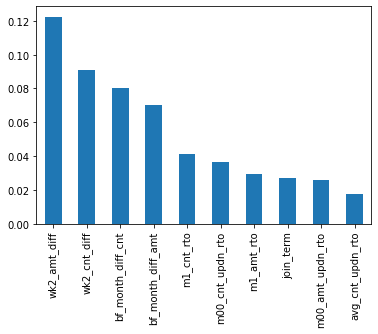

In [62]:
# 최근 2주간의 amt, cmt '변화' 
# 전월 대비 amt, cnt 변화
# 그 밖에 6개월 sum cnt 중에서 차지하는 비율 등 바로 직전 기간의 가맹점 실적이 중요한 변수로 보여짐
feature_scores[:10].plot(kind = 'bar')

In [66]:
for idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    best_model.fit(X_train, y_train)
    y_prob = best_model.predict_proba(X_test)
    y_pred = (y_prob[:,1] >= 0.35).astype("int")
    print(f"______________{idx}______________") 
    print(f"accuracy_score : {accuracy_score(y_test, y_pred):0.4f}")
    print(f"f1_score : {f1_score(y_test, y_pred):0.4f}")
    print(f"precision_score : {precision_score(y_test, y_pred):0.4f}")
    print(f"recall_score : {recall_score(y_test, y_pred):0.4f}")
    print(f"_______________________________") 

______________0______________
accuracy_score : 0.9546
f1_score : 0.6761
precision_score : 0.6522
recall_score : 0.7017
_______________________________
______________1______________
accuracy_score : 0.9554
f1_score : 0.6729
precision_score : 0.6667
recall_score : 0.6793
_______________________________
______________2______________
accuracy_score : 0.9547
f1_score : 0.6809
precision_score : 0.6495
recall_score : 0.7155
_______________________________


# Save Model

In [63]:
import joblib

In [67]:
joblib.dump(best_model, 'churn_model.pkl')

['churn_model.pkl']